In [1]:
from __future__ import division
import numpy as np
import numpy.ma as nma
from pio import imgio
import apply_mask
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
from matplotlib import colors as clr
import matplotlib.ticker as mtick
rc('text', usetex=True)
import scipy.ndimage as ndimage
from scipy.optimize import curve_fit
from scipy.signal import correlate2d
from scipy import stats
from copy import deepcopy
import cv2
import cmap_sunset
from datetime import datetime
%matplotlib inline

In [2]:
path = '/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/'
img_file = path+'plume_30um_dn32_D019/pano/Analysis/pano.img'
W_file = path+'plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.npz'
U_file = path+'plume_30um_dn32_D019/pano/Analysis/pano.0048.def.W.npz'
instantaneous_mask_file = path+'plume_30um_dn32_D019/pano/Analysis/pano.0048.def.mask.npz'
time_avg_mask_file= path+'plume_30um_dn32_D019/pano/Analysis/pano.0048.def.mask.tave_mask.npz'
Wave_file = path+'plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.ave.npz'
Wrms_file = path+'plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.rms.npz'

Uave_file = path+'/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.ave.npz'
Urms_file = path+'/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.rms.npz'

deltat = 1/600 #s
cal = 3581 #pix/m
D_0 = 1.905e-2 #m
dx = 24
outlet_z_pix = 197

In [3]:
img = imgio.imgio(img_file)

In [41]:
image.shape

(1100, 5120)

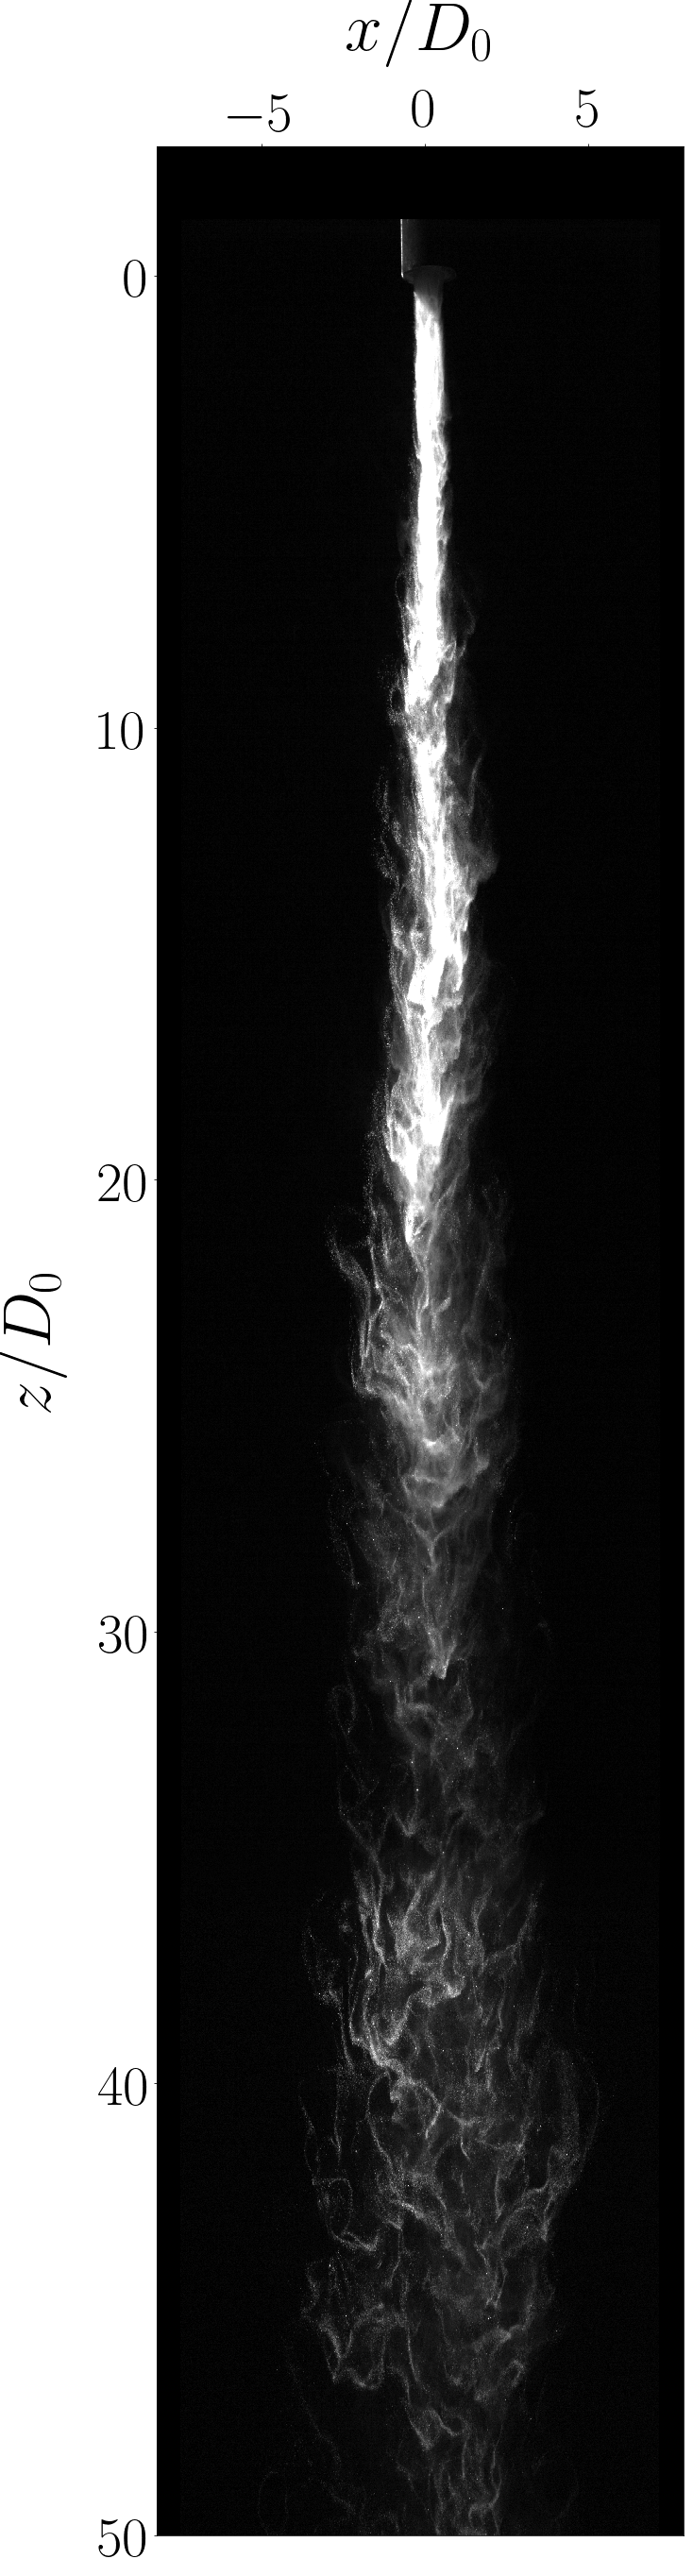

In [11]:
i1 = cv2.convertScaleAbs(img.read_frame2d(8005), alpha=(255.0/4096.0))
shape = np.array((1,i1.shape[1]/i1.shape[0]))*10
f,ax = plt.subplots(figsize=shape)
y = (np.arange(img.ix, 0,-1)-197)/cal/D_0
x = (np.arange(0,img.iy)-560)/cal/D_0
X,Y = np.meshgrid(x,y)
ax.pcolormesh(X,Y,np.rot90(i1),cmap=cm.gray,vmax=150);
ax.set_ylim(50,y[-1]);
ax.tick_params(axis='both', which='major', labelsize=60)
ax.set_ylabel('$z/D_0$',labelpad=25,fontsize=72)
ax.set_xlabel('$x/D_0$',labelpad=25,fontsize=72);
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top();
f.savefig('/home/alec/Desktop/i2.png',format='png',bbox_inches='tight',transparent=True,dpi=300)

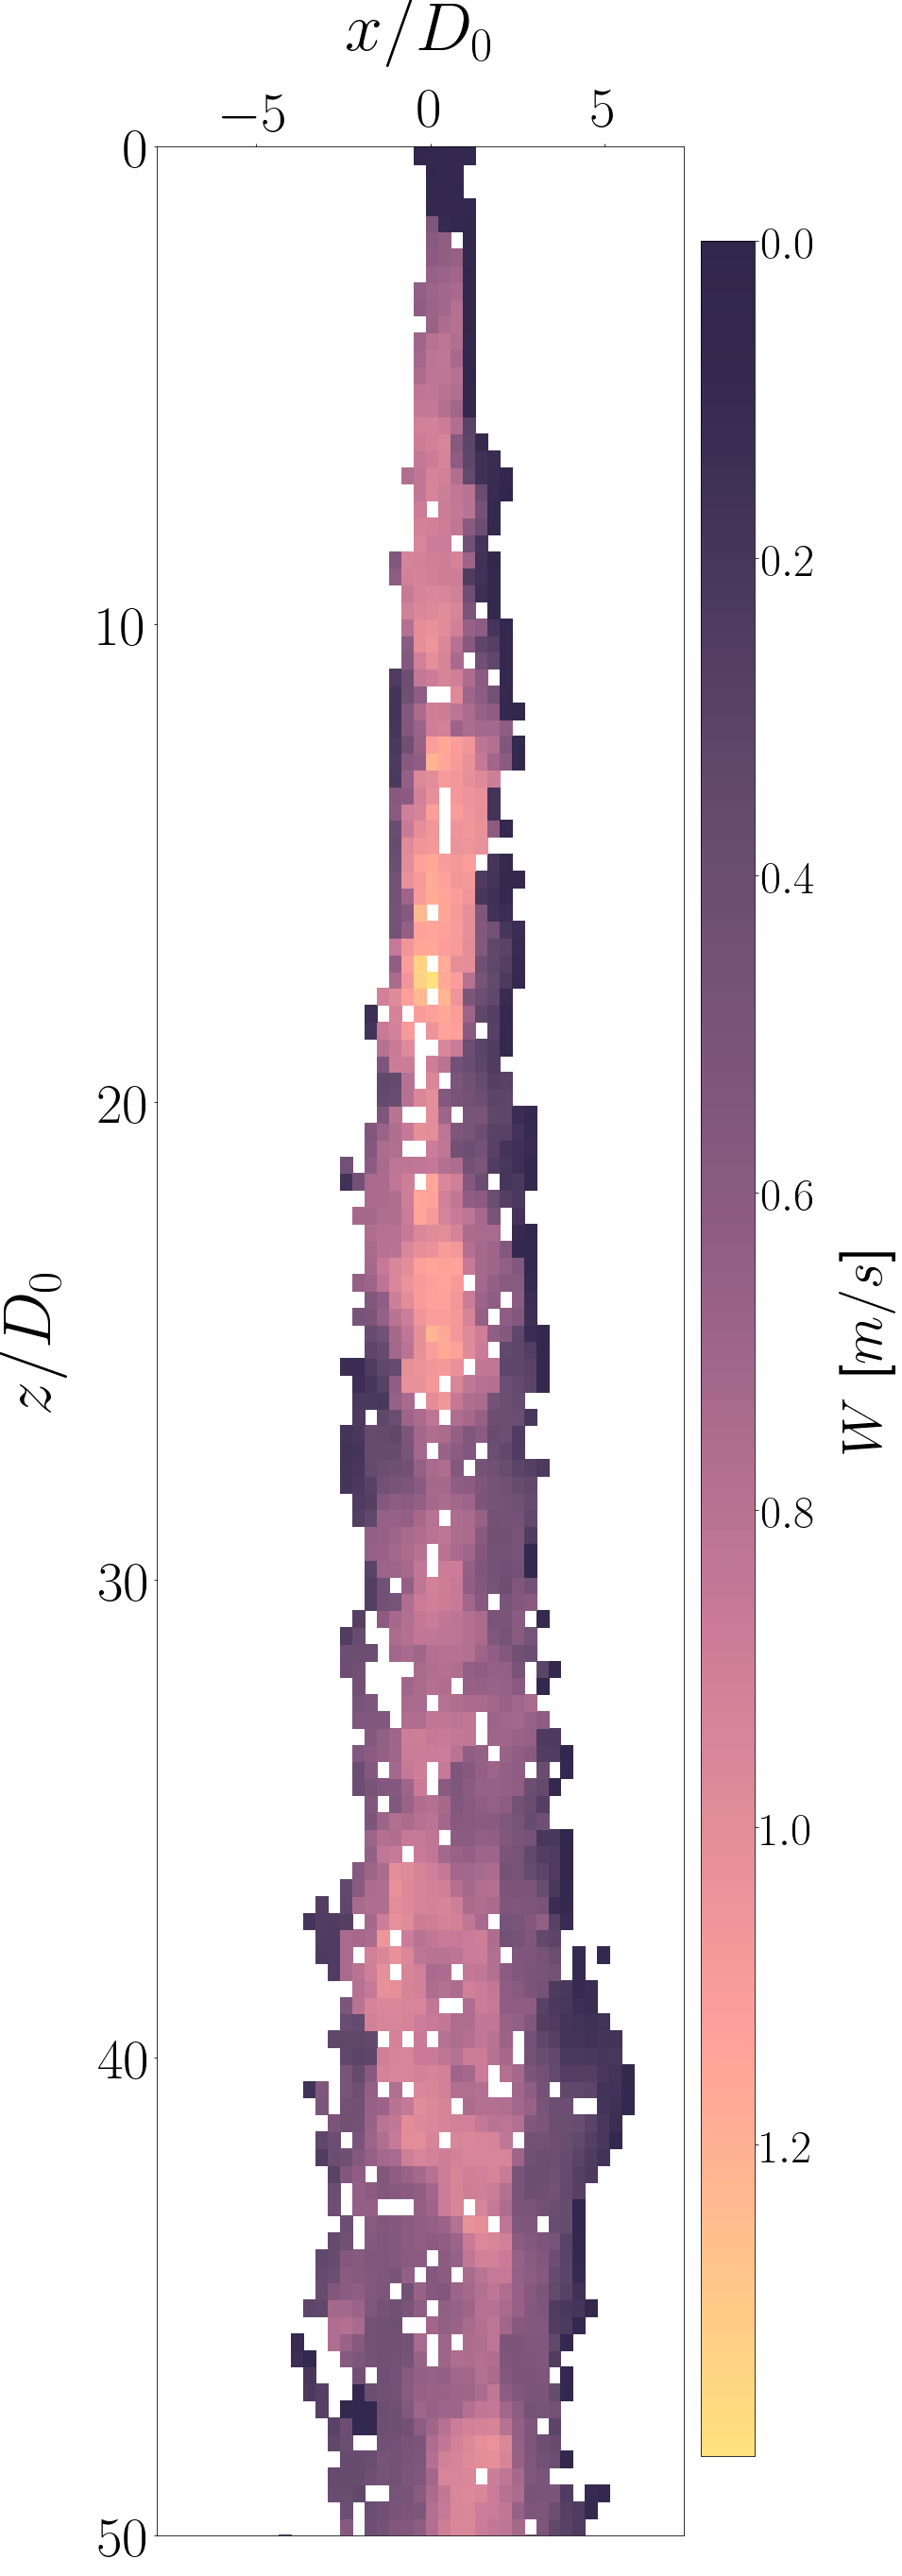

In [10]:
w1 = W_inst[8000,:,:]/cal/deltat
shape = np.array((1,i1.shape[1]/i1.shape[0]))*10
f,ax = plt.subplots(figsize=shape)
y = (np.arange(img.ix-dx, 0+dx,-dx)-197)/cal/D_0
x = (np.arange(0+dx,img.iy-dx,dx)-560)/cal/D_0
X,Y = np.meshgrid(x,y)
ax.pcolormesh(X,Y,np.rot90(w1),cmap='sunset');
ax.set_ylim(50,0);
ax.tick_params(axis='both', which='major', labelsize=60)
ax.set_ylabel('$z/D_0$',labelpad=25,fontsize=72)
ax.set_xlabel('$x/D_0$',labelpad=25,fontsize=72);
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top();
cbar_ax = f.add_axes([.925,.15,.08,.7])
cNorm = clr.Normalize(vmin=0,vmax=10/cal/deltat)
scalarMap = cm.ScalarMappable(norm=cNorm,cmap='sunset')
scalarMap.set_array(np.linspace(0,10/cal/deltat))
cb = f.colorbar(scalarMap,cax=cbar_ax);
cb.ax.invert_yaxis()
cb.set_label('$W$ [$m/s$]',labelpad=25,size=60)
cb.ax.tick_params(labelsize=48)

f.savefig('/home/alec/Desktop/w1.png',format='png',bbox_inches='tight',transparent=True,dpi=600)

# Liu Model

In [249]:
W_centerline = np.load(path+'plume_30um_dn32_D019/pano/Analysis/figures/centerline_W.npz')['arr_0']
beta_0 = 2e-2 # volume fraction
rho_p = 2500 # kg/m^3
rho_a = 1.225 # kg/m^3
g = 9.81 # m/s^2
w_0 = W_centerline[0]/2
r_0 = 0.01905 # m
dp = 30e-6 #m
tau_p = 7.4e-3 # s
mu_a = 1.825e-5 # kg m^-1 s^-1
Vp = np.pi*dp**3/6

steps = 500000
length = 50000
s = np.arange(0,length,length/steps)
s_size = np.diff(np.arange(1,length,length/steps))[0]
w_a0 = w_0-(tau_p*g)
r_a0 = r_0
alpha = 0.05
Q_a0 = np.pi*r_a0**2*w_a0
M_a0 = w_a0*Q_a0*rho_a
rho_b0 = rho_p*beta_0+rho_a*(1-beta_0)
m_dot0 = 0.00168#rho_b0*w_0/2*np.pi*r_a0**2 #kg/s


B = (rho_p - rho_a)*np.pi*g*beta_0*w_0*r_0**2
K1 = 15/2*np.pi*beta_0*w_0*r_0**2*rho_a**(-1/3)*mu_a**(2/3)*dp**(-5/3)

In [229]:
W_centerline[0]/2

0.5169451038795029

In [255]:
steps = len(s)
wp = np.zeros((steps+1,))
wa = np.zeros((steps+1,))
Qa = np.zeros((steps+1,))
Ma = np.zeros((steps+1,))
ra = np.zeros((steps+1,))
beta = np.zeros((steps+1,))
rho_b = np.zeros((steps+1,))
mp_dot = np.zeros((steps+1,))
wp[0] = w_0
wa[0] = w_a0
Qa[0] = Q_a0
ra[0] = r_0
Ma[0] = M_a0
beta[0] = beta_0
rho_b[0] = rho_b0
mp_dot[0] = m_dot0

C = np.zeros((steps+1))
C[0] = ((rho_p-rho_b[0])/(rho_p-rho_a))**(-4.7)
#cs=np.linspace(.1,100,100000)
#Rep = (rho_a*(w_0-w_a0)*dp)/mu_a
#Cd = 24*(1+0.15*Rep**.687)/Rep
#Fd = rho_a*(w_0-w_a0)**2/2*Cd/4*np.pi*dp**2*cs*6*beta_0*w_0*r_0**2/dp**3
#w = wp[0] + s_size/cal * (B-Fd)/(m_dot*wp[0])
#interp_diff = abs(w+np.interp(s[0],(Z[1:-1]),(nma.min(W_plume[1:-1,:],axis=1)/cal/deltat/2)))
#C[0] = cs[np.where(interp_diff==np.min(interp_diff))[0]]
#C[0]=1
for i,ii in enumerate(s):
    i=i+1
    ii=ii+s_size
    Rep = (rho_a*abs(wp[i-1]-wa[i-1])*dp)/mu_a
    Cd = 24*(1+0.15*Rep**.687)/Rep
    #Fd = rho_a*(wp[i-1]-wa[i-1])**2/2*Cd/4*np.pi*dp**2*C[0]*6*beta[0]*wp[i-1]*ra[0]**2/dp**3
    Fd = rho_a*(wp[i-1]-wa[i-1])**2/2*Cd/4*np.pi*dp**2*C[i-1]*6*beta[i-1]*wp[i-1]*ra[i-1]**2/dp**3
    B = (rho_p - rho_a)*np.pi*g*beta[i-1]*wp[i-1]*ra[i-1]**2
    wp[i] = wp[i-1] + s_size/cal * (B-Fd)/(mp_dot[0]*wp[i-1])
    Qa[i] = Qa[i-1] + s_size/cal * (2*np.pi*ra[i-1]*abs(wa[i-1])*alpha)
    Ma[i] = Ma[i-1] + s_size/cal * (Fd)/wp[i-1]
    wa[i] = Ma[i]/(Qa[i]*rho_a)
    ra[i] = np.sqrt(Qa[i]/(np.pi*abs(wa[i])))
    #mp_dot[i] = rho_b[i-1]*wp[i]*np.pi*ra[i]**2
    rho_b[i] = m_dot0/(wp[i]*np.pi*ra[i]**2) + rho_a
    C[i] = ((rho_p-rho_b[i])/(rho_p-rho_a))**(-4.7)
    
    #beta[i] = mp_dot[i]/(wp[i]*np.pi*ra[i]**2*(rho_p-rho_a))
    beta[i] = 1-(rho_p-rho_b[i])/(rho_p-rho_a)
    #beta[i] = (rho_a-rho_b[i])/(rho_p-rho_a)
    #Vps = 6*beta[i-1]*wp[i]*ra[i]**2/(dp**3)*Vp*s_size/cal/wp[i]
    #V_tot = np.pi/3*(ra[i-1]**2+ra[i]*ra[i-1]+ra[i]**2)*(s_size/cal)
    #Vps = mp_dot[i]/(Vp*rho_p)*(s_size/cal/wp[i])*Vp
    #beta[i] = Vps/V_tot
    

In [90]:
wp = np.zeros((steps+1,))
wa = np.zeros((steps+1,))
Qa = np.zeros((steps+1,))
Ma = np.zeros((steps+1,))
ra = np.zeros((steps+1,))
beta = np.zeros((steps+1,))
rho_b = np.zeros((steps+1,))
mp_dot = np.zeros((steps+1,))
wp[0] = w_0
wa[0] = w_a0
Qa[0] = Q_a0
ra[0] = r_0
Ma[0] = M_a0
beta[0] = beta_0
rho_b[0] = rho_b0
mp_dot[0] = m_dot0

In [118]:
i=1
Rep = (rho_a*abs(wp[i-1]-wa[i-1])*dp)/mu_a
Cd = 24*(1+0.15*Rep**.687)/Rep
Fd = rho_a*(wp[i-1]-wa[i-1])**2/2*Cd/4*np.pi*dp**2*C*6*beta[i-1]*w_0*r_0**2/dp**3
wp[i] = wp[i-1] + s_size/cal * (B-Fd)/(mp_dot[0]*wp[i-1])
Qa[i] = Qa[i-1] + s_size/cal * (2*np.pi*ra[i-1]*abs(wa[i-1])*alpha)
Ma[i] = Ma[i-1] + s_size/cal * (Fd)/wp[i-1]
wa[i] = Ma[i]/(Qa[i]*rho_a)
ra[i] = np.sqrt(Ma[i]/(np.pi*abs(wa[i])))

ValueError: setting an array element with a sequence.

In [64]:
Vps = 6*beta[i-1]*wp[i]*ra[i]**2/(dp**3)*Vp*s_size/cal/wp[i]
V_tot = np.pi/3*(ra[i-1]**2+ra[i]*ra[i-1]+ra[i]**2)
beta[i] = Vps/V_tot

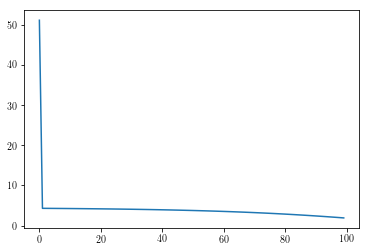

In [252]:
plt.plot(rho_b[0:100])

In [62]:
rho_b[i] = rho_p*beta[i-1]+rho_a*(1-beta[i-1])
mp_dot[i] = rho_b[i]*wp[i]*np.pi*ra[i]**2
beta[i] = mp_dot[i]/(wp[i]*np.pi*ra[i]**2*(rho_p-rho_a))
mp_dot

array([0.02574812, 0.02489442, 0.        , ..., 0.        , 0.        ,
       0.        ])

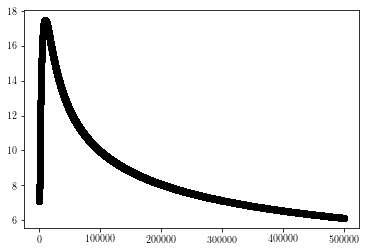

In [256]:
plt.plot((wp)/(tau_p*g),'ko')

# Initial Gamma Calculation

In [216]:
rho_p = 2500
rho_a = 1.225
beta_0 = 2.2e-2
alpha = 0.03
rho_b0 = rho_p*beta_0+rho_a*(1-beta_0)
Gamma_0 = (5*9.81*(1-rho_b0/rho_a)*(D_0/2)*np.sqrt(rho_b0/rho_a))/(8*alpha*-(W_centerline[0]/2)*2*(rho_b0/rho_a))
print('Gamma = %0.4f' %Gamma_0)

Gamma = 12.4750


# Pure Plume Model

#### non-Boussinesq

In [217]:
z_pb = np.linspace(0,75*D_0,2000)
r_0 = .41*D_0
Delta_0 = (1-rho_a/rho_b0)/(rho_a/rho_b0)
r_pnb = r_0*3/10*(10/3+(4*alpha*z_pb)/r_0)
w_pnb = W_centerline[0]/2*(10/3)**(1/3)*(10/3+(4*alpha*z_pb)/(r_0))**(-1/3)
Delta_pnb = Delta_0*(10/3)**(5/3)*(10/3+(4*alpha*z_pb)/r_0)**(-5/3)
rho_b_pnb = rho_a*(Delta_pnb+1)
beta_pnb = (rho_a -rho_b_pnb)/(rho_a-rho_p)

# Lazy Plume Model

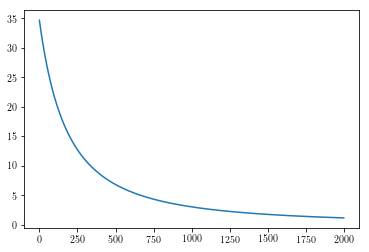

In [199]:
plt.plot(Delta_pnb)

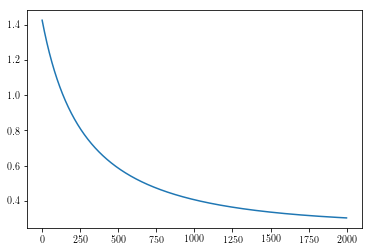

In [218]:
plt.plot(rho_b_pnb*w_pnb*np.pi*2*r_pnb)

In [148]:
Delta_0

-0.9719706412488052

# Mean Velocity

In [4]:
W_inst = apply_mask.apply_mask(W_file,instantaneous_mask_file)
W_mean = apply_mask.apply_mask(Wave_file,time_avg_mask_file)

In [ ]:
x = np.arange(0+dx, img.ix-dx,dx)
y = np.arange(0+dx,img.iy-dx,dx)
X,Y = np.meshgrid(x,y)

In [12]:
W_inst.shape

(19948, 44, 212)

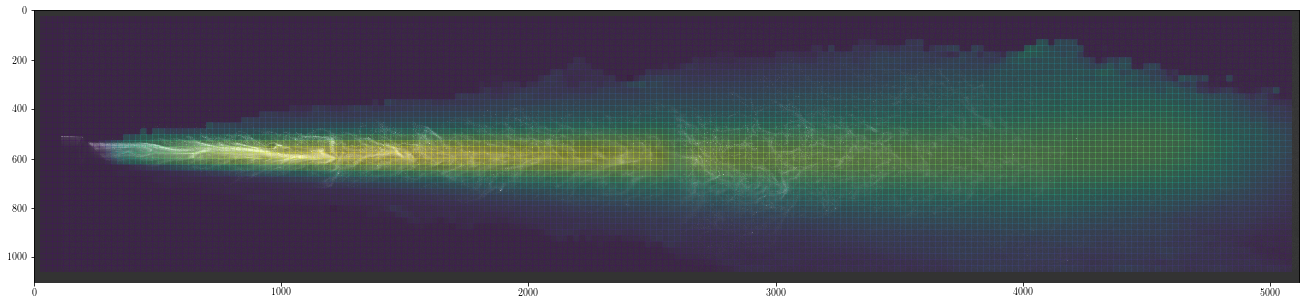

In [385]:
f,ax = plt.subplots(figsize=(5*img.ix/img.iy,5*1))
ax.pcolormesh(X,Y,W_mean.data,alpha=0.3)
ax.imshow(img.read_frame2d(1000),alpha=0.8,cmap=cm.gray)
#ax.set_xlim(0,311)
#ax.set_ylim(1050,1100)

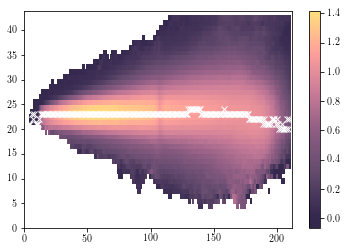

In [37]:
x = np.arange(0+dx, img.ix-dx,dx)
y = np.arange(0+dx,img.iy-dx,dx)
X,Y = np.meshgrid(x,y)
plt.pcolormesh(W_mean/cal/deltat,cmap='sunset')
plt.colorbar()
plt.plot(((centerline[0])),(centerline[1]),'wx')
#plt.xlim(60,120)

In [265]:
mask_zlocs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,103,104,105,106,107,108,109,110,111]

additional_mask = np.load(time_avg_mask_file)['arr_0']
for c in mask_zlocs:
    additional_mask[:,c] = 1
W_mean = nma.masked_array(W_mean, mask=additional_mask)
np.savez_compressed(path+'tave_mask_edited.npz', additional_mask)

In [266]:
centerline = np.zeros((2,W_mean.shape[1]))
for r in range(0,W_mean.shape[1]):
    centerline[0,r] = int(r)#((r*dx+dx+0.5)-outlet_z_pix)
    try:
        centerline[1,r] = int(np.where(W_mean[:,r] == nma.max(W_mean[:,:],axis=0)[r])[0])
    except:
        centerline[1,r] = np.nan
np.savez_compressed(path+'plume_30um_dn32_D019/pano/Analysis/figures/centerline_W.npz',nma.max(W_mean[:,:],axis=0)[~np.isnan(centerline[1])].data/cal/deltat)
centerline = centerline[:,~np.isnan(centerline[1])].astype('int')
np.savez_compressed(path+'plume_30um_dn32_D019/pano/Analysis/figures/centerline_xz_pos.npz',centerline)

In [5]:
W_centerline = np.load(path+'plume_30um_dn32_D019/pano/Analysis/figures/centerline_W.npz')['arr_0']
centerline = np.load(path+'plume_30um_dn32_D019/pano/Analysis/figures/centerline_xz_pos.npz')['arr_0']

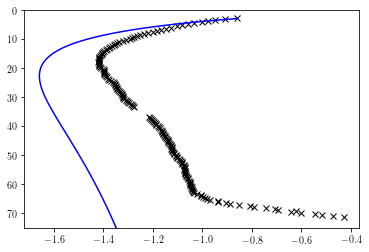

In [140]:
plt.plot(-W_centerline,((centerline[0]*dx+dx+0.5)-outlet_z_pix)/cal/D_0,'kx')
plt.plot(-wp[:-1],s/cal/D_0,'b-')
plt.ylim(75,0);

In [24]:
z_vel_profs = [5,10,18,25,40,50,57,64,70]
d_from_c = (np.arange(0,W_mean.shape[0])-23)*dx/cal/D_0


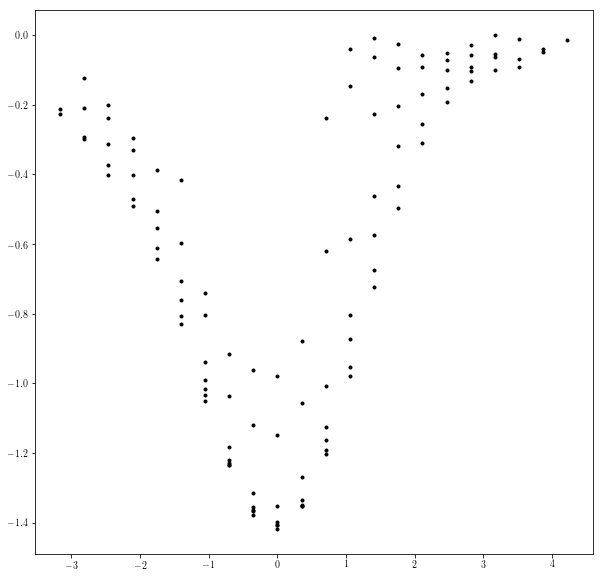

In [45]:
f,ax = plt.subplots(figsize=(10,10))
for z in z_vel_profs:
    ax.plot(d_from_c,-W_mean[:,z]/cal/deltat,'k.')

# Concentration

In [22]:
mean_c = img.read_frame2d(0).astype(int)
for f in range(1,img.it):
    t = img.read_frame2d(f)
    mean_c += t
mean_c = (mean_c / img.it)

In [538]:
len(slices), W_mean.shape[0]*W_mean.shape[1]

(9328, 9328)

In [4]:
c = imgio.imgio('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/concentration/dn_58_2in/Raw/pano.avg.img').read_frame2d(0)

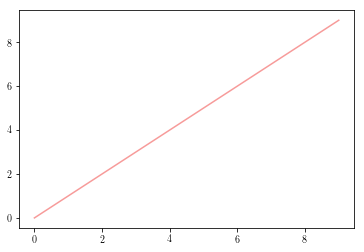

In [411]:
plt.plot(np.arange(0,10),c=np.array(cmap_sunset.cmap(200)))

In [399]:
clr.to_hex(cmap_sunset.cmap(0.5))

u'#9f668a'

In [402]:
np.array(cmap_sunset.cmap(0.5))

array([0.62535948, 0.39895425, 0.54013072, 1.        ])

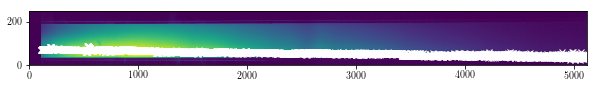

In [413]:
f,ax = plt.subplots(figsize=(10,1))
ax.pcolormesh(c)
ax.plot(cc[0],cc[1],'wx')

In [426]:
cc = np.zeros((2,c.shape[1]))
for r in range(0,c.shape[1]):
    cc[0,r] = int(r)#((r*dx+dx+0.5)-outlet_z_pix)
    try:
        cc[1,r] = int(np.where(c[:,r] == nma.max(c[:,:],axis=0)[r])[0])
    except:
        cc[1,r] = np.nan

In [427]:
cc = cc[:,~np.isnan(cc[1])].astype('int')

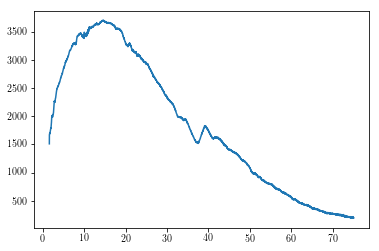

In [416]:
plt.plot(cc[0]/cal/D_0,c[cc[1],cc[0]])

In [428]:
ccc = stats.binned_statistic(cc[0],c[cc[1],cc[0]],bins=4000,statistic='mean')

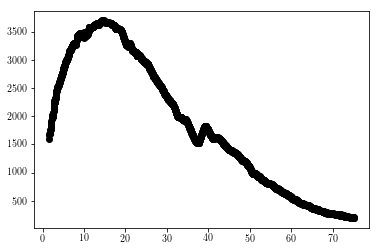

In [421]:
plt.plot(ccc[1][1:]/cal/D_0,ccc[0],'ko')

In [432]:
a2 = np.zeros(len(ccc[0]))
for i in range(0,len(ccc[0])):
    a2[i] = 1.26e-3/c[cc[1],cc[0]][i]

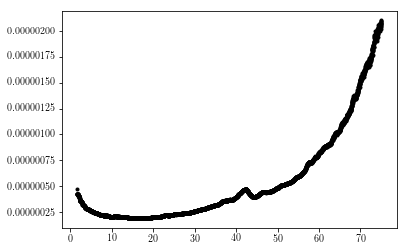

In [436]:
plt.plot(ccc[1][1:]/cal/D_0,a,'k.')

In [405]:
c_map = np.zeros(W_inst.shape)
for f in range(0,W_inst.shape[0]):
    for r in range(int(dx),int(img.iy-(dx)),dx):
        for c in range(int(dx),int(img.ix - (dx)),dx):
            c_map[f,int(r/dx)-1,int(c/dx)-1] = np.mean(img.read_frame2d(f)[slice(r,r+dx,1),slice(c,c+dx,1)])


KeyboardInterrupt: 

In [555]:
n_row_slices = int((img.read_frame2d(0).shape[0]-2*dx)/dx)
n_col_slices = int((img.read_frame2d(0).shape[1]-dx)/dx)
slices = []
for i in x:
    for j in y:
        slices.append((slice(j,j+dx),slice(i,i+dx)))

In [ ]:
c_map = np.zeros(W_inst.shape)
tic = datetime.now()
for f in range(438,W_inst.shape[0]):
    for s in slices:
        c_map[f,int(s[0].start/dx-1),int(s[1].start/dx-1)] = np.mean(img.read_frame2d(f)[s])

In [566]:
t = np.zeros((3,3))
s = [1,2,3,4,5,6,7,8,9]
t = [i for i in s]

SyntaxError: invalid syntax (<ipython-input-566-1499af3d11d5>, line 3)

In [593]:
f

438

In [587]:
int(s[0].start/dx-1),int(s[1].start/dx-1)

(0, 211)

In [ ]:
plt.pcolormesh(c_map[0,:,:],cmap='sunset')
plt.colorbar()

In [397]:
c_bar_w_bar = c_map*W_mean

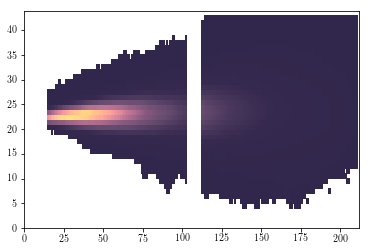

In [398]:
plt.pcolormesh(c_bar_w_bar,cmap='sunset')

In [ ]:
cw = W_inst*c_map
cw_bar = nma.mean(cw,axis=0)
np.savez_compress(path+'figures/avg_mass_flux.npz',cw_bar)

In [401]:
mf = []
for i in range(0,W_mean.shape[1]):
    mf.append(nma.sum(c_bar_w_bar[0:24,i]))

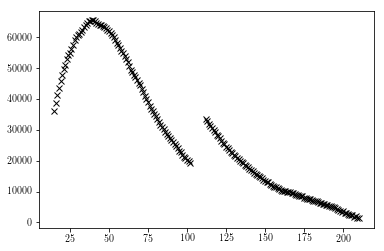

In [402]:
plt.plot(mf,'kx')

# Turblent cases

In [6]:
imgt1_file = path+'plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/pano.img'
Wt1_file = path+'plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/pano.0048.def.U.npz'
Ut1_file = path+'plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/pano.0048.def.W.npz'
instantaneous_mask_file_t1 = path+'plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/pano.0048.def.mask.npz'
time_avg_mask_file_t1 = path+'plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/pano.0048.def.mask.tave_mask.npz'
Wave_t1_file = path+'plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/pano.0048.def.U.ave.npz'
Wrms_t1_file = path+'plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/pano.0048.def.U.rms.npz'

Uave_t1_file = path+'plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/pano.0048.def.U.ave.npz'
Urms_t1_file = path+'plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/pano.0048.def.U.rms.npz'


dx = 24
imgt2_file = path+'plume_30um_dn32_D019/turbulent/pano/Run3/Analysis/pano.img'
Wt2_file = path+'plume_30um_dn32_D019/turbulent/pano/Run3/Analysis/pano.0048.def.U.npz'
Ut2_file = path+'plume_30um_dn32_D019/turbulent/pano/Run3/Analysis/pano.0048.def.W.npz'
instantaneous_mask_file_t2 = path+'plume_30um_dn32_D019/turbulent/pano/Run3/Analysis/pano.0048.def.mask.npz'
time_avg_mask_file_t2 = path+'plume_30um_dn32_D019/turbulent/pano/Run3/Analysis/pano.0048.def.mask.tave_mask.npz'
Wave_t2_file = path+'plume_30um_dn32_D019/turbulent/pano/Run3/Analysis/pano.0048.def.U.ave.npz'
Wrms_t2_file = path+'plume_30um_dn32_D019/turbulent/pano/Run3/Analysis/pano.0048.def.U.rms.npz'

Uave_t2_file = path+'plume_30um_dn32_D019/turbulent/pano/Run3/Analysis/pano.0048.def.U.ave.npz'
Urms_t2_file = path+'plume_30um_dn32_D019/turbulent/pano/Run3/Analysis/pano.0048.def.U.rms.npz'

#Wt1_inst = apply_mask.apply_mask(Wt1_file,instantaneous_mask_file_t1)
Wt1_mean = apply_mask.apply_mask(Wave_t1_file,time_avg_mask_file_t1)
#Wt2_inst = apply_mask.apply_mask(Wt2_file,instantaneous_mask_file_t2)
Wt2_mean = apply_mask.apply_mask(Wave_t2_file,time_avg_mask_file_t2)

In [6]:
mask_zlocs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#,103,104,105,106,107,108,109,110,111
additional_mask = np.load(time_avg_mask_file_t1)['arr_0']
for c in mask_zlocs:
    additional_mask[:,c] = 1
Wt1_mean = nma.masked_array(Wt1_mean, mask=additional_mask)
np.savez_compressed(path+'plume_30um_dn32_D019/turbulent/pano/Run2/tave2_mask_edited.npz', additional_mask)

In [7]:
additional_mask = np.load(time_avg_mask_file_t2)['arr_0']
for c in mask_zlocs:
    additional_mask[:,c] = 1
Wt2_mean = nma.masked_array(Wt2_mean, mask=additional_mask)
np.savez_compressed(path+'plume_30um_dn32_D019/turbulent/pano/Run3/tave3_mask_edited.npz', additional_mask)

In [487]:
centerline = np.zeros((2,Wt1_mean.shape[1]))
for r in range(0,Wt1_mean.shape[1]):
    centerline[0,r] = int(r)#((r*dx+dx+0.5)-outlet_z_pix)
    try:
        centerline[1,r] = int(np.where(Wt1_mean[:,r] == nma.max(Wt1_mean[33:50,:],axis=0)[r])[0])
    except:
        centerline[1,r] = np.nan
np.savez_compressed(path+'plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/centerline_W.npz',nma.max(Wt1_mean[:,:],axis=0)[~np.isnan(centerline[1])].data/cal/deltat)
centerline_t1 = centerline[:,~np.isnan(centerline[1])].astype('int')
np.savez_compressed(path+'plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/centerline_xz_pos.npz',centerline_t1)

In [71]:
W_centerline_t1 = np.load(path+'plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/centerline_W.npz')['arr_0']
centerline_t1 = np.load(path+'plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/centerline_xz_pos.npz')['arr_0']
W_centerline_t2 = np.load(path+'plume_30um_dn32_D019/turbulent/pano/Run3/Analysis/centerline_W.npz')['arr_0']
centerline_t2 = np.load(path+'plume_30um_dn32_D019/turbulent/pano/Run3/Analysis/centerline_xz_pos.npz')['arr_0']

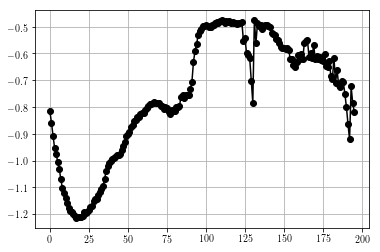

In [493]:
plt.plot(-W_centerline_t1,'ko-')
plt.grid()
#plt.ylim(75,0);

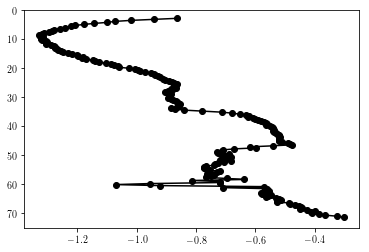

In [490]:
plt.plot(-W_centerline_t2,((centerline_t2[0]*dx+dx+0.5)-outlet_z_pix)/cal/D_0,'ko-')
plt.ylim(75,0);

In [72]:
W_centerline_t = (W_centerline_t1 + W_centerline_t2)/2

In [123]:
g

<function __main__.<lambda>>

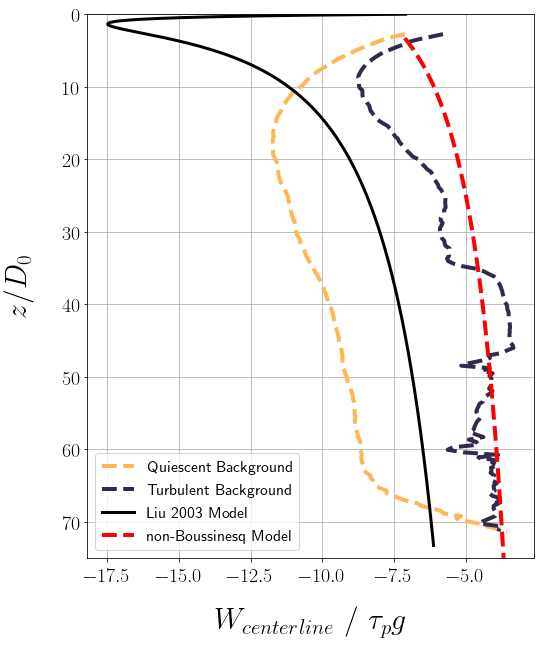

In [260]:
f,ax = plt.subplots(figsize=(8,10))
g = 9.81
ax.plot(-W_centerline/(2*tau_p*g),((centerline[0]*dx+dx+0.5)-outlet_z_pix)/cal/D_0,'--',linewidth=4,color='#ffb755')
ax.plot(-W_centerline_t/(2*tau_p*g),((centerline_t2[0]*dx+dx+0.5)-outlet_z_pix)/cal/D_0,'--',linewidth=4,color=cmap_sunset.cmap(10))
ax.plot(-wp[1:]/(tau_p*g),np.linspace(0,s_size/cal*length/D_0,steps),'k',linewidth=3)
ax.plot(-w_pnb/(tau_p*g),(z_pb)/D_0+3.3,'--',linewidth=4,color='r')

ax.set_ylim(75,0);
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('$z/D_0$',labelpad=25,fontsize=30)
ax.set_xlabel(r'$W_{centerline}$ $/$ $\tau_pg$',labelpad=25,fontsize=30);
ax.legend(['Quiescent Background','Turbulent Background','Liu 2003 Model','non-Boussinesq Model'],fontsize=16);
#f.savefig('/media/alec/Photography/AGU_2019/centerline_W.pdf',format='pdf',bbox_inches='tight',transparent=True)

(100, 115)

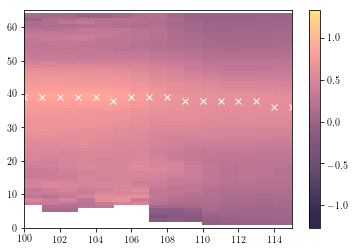

In [242]:
x = np.arange(0+dx, img.ix-dx,dx)
y = np.arange(0+dx,img.iy-dx,dx)
X,Y = np.meshgrid(x,y)
plt.pcolormesh(Wt2_mean/cal/deltat,cmap='sunset')
plt.colorbar()
plt.plot(((centerline_t2[0])),(centerline_t2[1]),'wx')
plt.xlim(100,115)

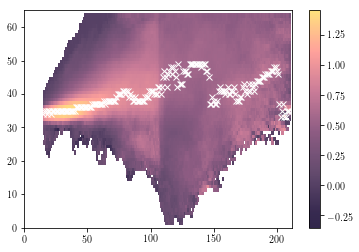

In [240]:
x = np.arange(0+dx, img.ix-dx,dx)
y = np.arange(0+dx,img.iy-dx,dx)
X,Y = np.meshgrid(x,y)
plt.pcolormesh(Wt1_mean/cal/deltat,cmap='sunset')
plt.colorbar()
plt.plot(((centerline_t1[0])),(centerline_t1[1]),'wx')

In [89]:
path = '/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/'
img_file = path+'plume_30um_dn32_D019/pano/Analysis/pano.avg.img'
deltat = 1/500 #s
cal = 3581 #pix/m
D_0 = 1.905e-2 #m
dx = 24
outlet_z_pix = 197
image = imgio.imgio(img_file).read_frame2d(0)
#%% concentration calibration images
c1 = imgio.imgio('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/concentration/dn_235_2in/Raw/pano.avg.img').read_frame2d(0)
c2 = imgio.imgio('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/concentration/dn_32_2in/Raw/pano.avg.img').read_frame2d(0)
c3 = imgio.imgio('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/concentration/dn_235_1in/Raw/pano.avg.img').read_frame2d(0)
#c4 = imgio.imgio('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/concentration/dn_465_1in/Raw/pano.avg.img').read_frame2d(0)
#c5 = imgio.imgio('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/concentration/dn_58_1in/Raw/pano.avg.img').read_frame2d(0)

In [10]:
c_imgs = [c1,c2,c3]
phis = [1.6e-3,3.6e-3,6.5e-3]
centerlines= []
for c in c_imgs:
    cc = np.zeros((2,c.shape[1]))
    for r in range(0,c.shape[1]):
        cc[0,r] = int(r)#((r*dx+dx+0.5)-outlet_z_pix)
        try:
            cc[1,r] = int(np.where(c[:,r] == nma.max(c[:,:],axis=0)[r])[0])
        except:
            cc[1,r] = np.nan
    cc = cc[:,~np.isnan(cc[1])].astype('int')
    centerlines.append(cc[:,cc[0]>=outlet_z_pix])


In [11]:
#%%
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

In [136]:
alphas.shape

(100,)

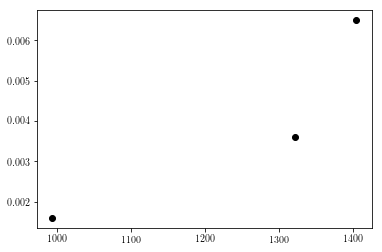

In [12]:
nbins=1700
#nbins=10
to_calc = []
for i,img in enumerate(c_imgs):
    a = []
    for i in range(0,len(centerlines[i][1])):
        a.append(np.mean(img[100:150,centerlines[0][0][i]]))
    to_calc.append(np.array(a))
c1_stats = stats.binned_statistic(centerlines[0][0],to_calc[0],statistic='mean',bins=nbins)
c2_stats = stats.binned_statistic(centerlines[1][0],to_calc[1],statistic='mean',bins=nbins)
c3_stats = stats.binned_statistic(centerlines[2][0],to_calc[2],statistic='mean',bins=nbins)
#c4_stats = stats.binned_statistic(centerlines[3][0],to_calc[3],statistic='mean',bins=nbins)
#c5_stats = stats.binned_statistic(centerlines[4][0],to_calc[4],statistic='mean',bins=nbins)
plot_bins = c1_stats.bin_edges+(np.diff(c1_stats.bin_edges)[0]/2)
c_stats = [c1_stats.statistic,c2_stats.statistic,c3_stats.statistic]
plt.figure();plt.plot([c[1] for c in c_stats],phis,'ko')
alphas = []
r_sqr = []
for i in range(0,nbins):
    p=np.polyfit([c[i] for c in c_stats],phis,1)[0]
    alphas.append(p)
    r_sqr.append(rsquared(phis,[p*c[i] for c in c_stats]))
alphas = np.array(alphas)

In [13]:
np.savetxt('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/concentration/alphas.txt',alphas)
np.savetxt('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/concentration/cmap_bins.txt',c1_stats.bin_edges.astype('int'))

In [133]:
cmap_bins

array([ 197,  199,  202, ..., 5113, 5116, 5119])

In [86]:
alphas = np.loadtxt('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/concentration/alphas.txt')
cmap_bins = np.loadtxt('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/concentration/cmap_bins.txt').astype('int')

In [87]:
t1_image = imgio.imgio('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/turbulent/pano/Run2/Analysis/pano.avg.img').read_frame2d(0)
t2_image = imgio.imgio('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/turbulent/pano/Run3/Analysis/pano.avg.img').read_frame2d(0)

In [90]:
# quiescent concentration
#cmap_bins = c1_stats.bin_edges.astype('int')
c_image = np.zeros(image.shape)
image_filt = deepcopy(image)
#image_filt[image_filt<70] = 0
for i in range(1,len(cmap_bins)):
    c_image[:,cmap_bins[i-1]-1:cmap_bins[i]+1] = image_filt[:,cmap_bins[i-1]-1:cmap_bins[i]+1]*ndimage.filters.gaussian_filter1d(alphas,100)[i-1]

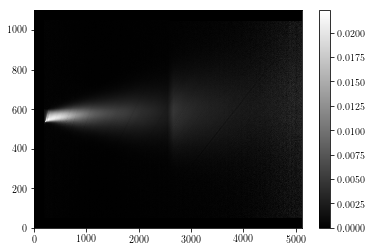

In [140]:
plt.pcolormesh(c_image,cmap=cm.gray);plt.colorbar()
#plt.xlim(197,500)
#plt.ylim(23*dx,24*dx)

array([43, 43, 43, ..., 88, 88, 87])

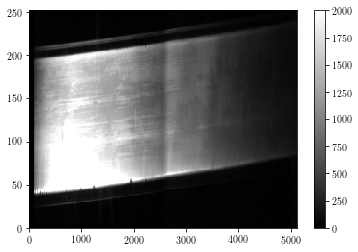

In [207]:
plt.pcolormesh(c1,cmap=cm.gray,vmax = 2000);plt.colorbar()
centerlines[0][1]

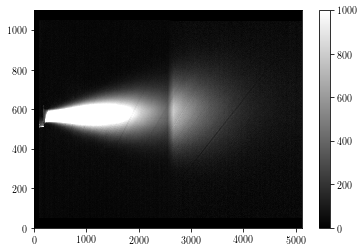

In [495]:
plt.pcolormesh(image,cmap=cm.gray,vmin=0,vmax=1000);plt.colorbar()
#plt.xlim(197,500)
#plt.ylim(23*dx,24*dx)

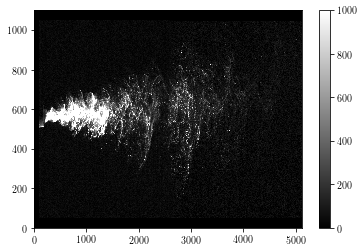

In [505]:
plt.pcolormesh(img.read_frame2d(3000),cmap=cm.gray,vmin=0,vmax=3000);plt.colorbar()


In [501]:
img.read_frame2d(0).shape

(1100, 5120)

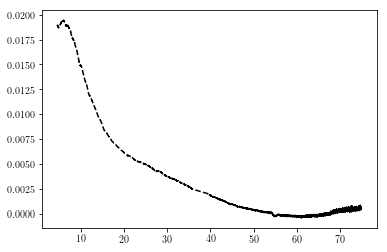

In [101]:
fix = np.mean(c_image[(23*dx):(24*dx),102*dx],axis=0)/np.mean(c_image[(23*dx):(24*dx),112*dx],axis=0)
fix = -np.polyfit(np.arange(102*dx,112*dx),np.mean(c_image[(23*dx):(24*dx),102*dx:112*dx],axis=0),1)[0]*(dx*112-dx*102)
CC = np.hstack((np.mean(c_image[(23*dx):(24*dx),300:102*dx],axis=0),np.mean(c_image[(23*dx):(24*dx),112*dx:]+fix,axis=0)))
z = np.hstack((np.arange(0,102*dx)[300:],np.arange(112*dx,5120)))/cal/D_0
plt.plot(z,CC,'k--')
CC[CC<0] = 0

In [93]:
t_image = (t1_image+t2_image)/2

In [94]:
# quiescent concentration
#cmap_bins = c1_stats.bin_edges.astype('int')
ct_image = np.zeros(t_image.shape)
image_filt = deepcopy(t_image)
image_filt[image_filt<50] = 0
for i in range(1,len(cmap_bins)):
    ct_image[:,cmap_bins[i-1]-1:cmap_bins[i]+1] = image_filt[:,cmap_bins[i-1]-1:cmap_bins[i]+1]*ndimage.filters.gaussian_filter1d(alphas,100)[i-1]

In [95]:
fix = -np.polyfit(np.arange(102*dx,112*dx),np.mean(ct_image[(34*dx):(35*dx),102*dx:112*dx],axis=0),1)[0]*(dx*112-dx*102)
CCt = np.hstack((np.mean(ct_image[(34*dx):(35*dx),300:102*dx],axis=0),np.mean(ct_image[(34*dx):(35*dx),112*dx:]+fix,axis=0)))
zt = np.hstack((np.arange(0,102*dx)[300:],np.arange(112*dx,5120)))/cal/D_0
CCt[CCt<0] = 0

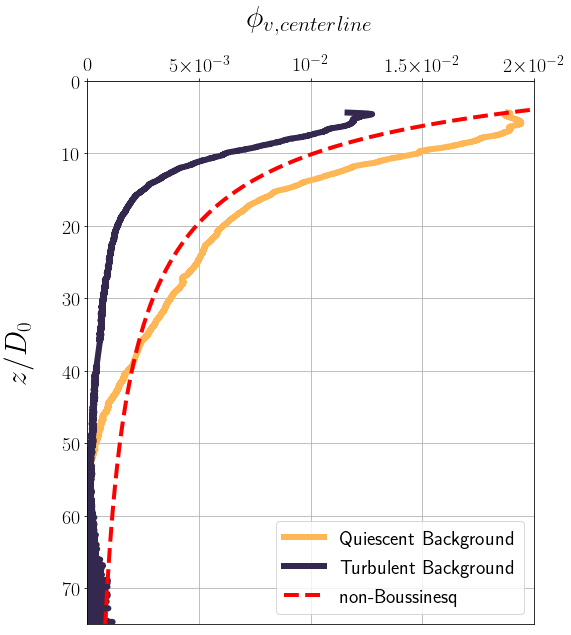

In [246]:
f,ax = plt.subplots(figsize=(8,10))
ax.plot(CC,z,'-',linewidth=6,color='#ffb755')
ax.plot(CCt,zt,'-',linewidth=6,color=cmap_sunset.cmap(10))
#ax.plot(beta[1:],np.linspace(0,s_size/cal*length/D_0,steps),'k',linewidth=3)
ax.plot(beta_pnb,(z_pb)/D_0+3.3,'--',linewidth=4,color='r')

ax.set_ylim(75,0);
ax.set_xlim(0,2e-2);
ff = mtick.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(ff._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(g))
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('$z/D_0$',labelpad=25,fontsize=30)
ax.set_xlabel('$\phi_{v,centerline}$',labelpad=25,fontsize=30);
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.grid()
ax.legend(['Quiescent Background','Turbulent Background','non-Boussinesq'],fontsize=20);
#f.savefig('/media/alec/882A5E9D2A5E87D8/Users/Alec/Documents/Coletti/Presentations/AGU_2019/centerline_phi.pdf',format='pdf',bbox_inches='tight',transparent=True)

In [109]:
def gaussian(x, a, x0, sigma, offset):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+offset

In [110]:
widths = []
widths_loc = []
widths_t = []
widths_t_loc = []
x = np.arange(0,image.shape[0])
xt = np.arange(0,t_image.shape[0])
for c in range(300,5120):
    #plt.plot(image[:,c],'ko')
    #plt.plot(gaussian(x,popt[0],popt[1],popt[2]),'r-')
    y = image[:,c]
    max_std = 800# (np.where(image[:,c]>60)[0][-1]-np.where(image[:,c]>60)[0][1])/2
    min_std=20
    min_offset = image[:,c].min()
    max_offset = np.max(image[0:400,c])
    guess_std = (np.where(t_image[:,c]>60)[0][-1]-np.where(t_image[:,c]>60)[0][1])/4
    try:
        popt,pcov = curve_fit(gaussian,x,y,p0=[y.max(),600,guess_std,10],bounds=((y.max()-50,400,min_std,min_offset),(y.max()+10,800,max_std,max_offset)))
        w = 1/np.e*(gaussian(x,popt[0],popt[1],popt[2],popt[3]).max()-popt[3])
        first = np.where((gaussian(x,popt[0],popt[1],popt[2],popt[3])-popt[3])>w)[0][0]
        middle = np.where(gaussian(x,popt[0],popt[1],popt[2],popt[3])-popt[3]==gaussian(x,popt[0],popt[1],popt[2],popt[3]).max()-popt[3])[0]
        width = middle-first
        widths.append(popt[2]/cal/D_0*np.sqrt(2))
        widths_loc.append(c)
    except (RuntimeError, ValueError):
        popt,pcov = curve_fit(gaussian,x,y,p0=[y.max(),600,guess_std,np.mean(image[0:200,c])],bounds=((y.max()-50,400,min_std,min_offset),(y.max()+50,900,800,max_offset)))
        w = 1/np.e*(gaussian(x,popt[0],popt[1],popt[2],popt[3]).max()-popt[3])
        first = np.where((gaussian(x,popt[0],popt[1],popt[2],popt[3])-popt[3])>w)[0][0]
        middle = np.where(gaussian(x,popt[0],popt[1],popt[2],popt[3])-popt[3]==gaussian(x,popt[0],popt[1],popt[2],popt[3]).max()-popt[3])[0]
        width = middle-first
        widths.append(popt[2]/cal/D_0*np.sqrt(2))
        widths_loc.append(c)

    
    y = t_image[:,c]
    max_std = 800# (np.where(t_image[:,c]>60)[0][-1]-np.where(t_image[:,c]>60)[0][1])/
    min_std=20
    min_offset = t_image[:,c].min()
    max_offset = np.max(t_image[0:400,c])
    guess_std = (np.where(t_image[:,c]>60)[0][-1]-np.where(t_image[:,c]>60)[0][1])/4
    try:
        popt,pcov = curve_fit(gaussian,xt,y,p0=[y.max(),900,guess_std,10],bounds=((y.max()-50,700,min_std,min_offset),(y.max()+10,1200,800,max_offset)))
        w = 1/np.e*(gaussian(x,popt[0],popt[1],popt[2],popt[3]).max()-popt[3])
        first = np.where((gaussian(x,popt[0],popt[1],popt[2],popt[3])-popt[3])>w)[0][0]
        middle = np.where(gaussian(x,popt[0],popt[1],popt[2],popt[3])-popt[3]==gaussian(x,popt[0],popt[1],popt[2],popt[3]).max()-popt[3])[0]
        width = middle-first
        widths_t.append(popt[2]/cal/D_0*np.sqrt(2))
        widths_t_loc.append(c)
    except (RuntimeError, ValueError):
        popt,pcov = curve_fit(gaussian,xt,y,p0=[y.max(),900,(np.where(t_image[:,c]>60)[0][-1]-np.where(t_image[:,c]>60)[0][1])/4,30])
        w = 1/np.e*(gaussian(x,popt[0],popt[1],popt[2],popt[3]).max()-popt[3])
        first = np.where((gaussian(x,popt[0],popt[1],popt[2],popt[3])-popt[3])>w)[0][0]
        middle = np.where(gaussian(x,popt[0],popt[1],popt[2],popt[3])-popt[3]==gaussian(x,popt[0],popt[1],popt[2],popt[3]).max()-popt[3])[0]
        width = middle-first
        widths_t.append(popt[2]/cal/D_0*np.sqrt(2))
        widths_t_loc.append(c)

widths = np.array(widths)
widths_t = np.array(widths_t)
widths_loc = np.array(widths_loc)
widths_t_loc = np.array(widths_t_loc)

In [117]:
widths[0]

0.4146156515388802

In [31]:
np.savetxt('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/widths.txt',widths)
np.savetxt('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/widths_loc.txt',widths_loc)
np.savetxt('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/widths_t.txt',widths_t)
np.savetxt('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/widths_t_loc.txt',widths_t_loc)

In [104]:
widths = np.loadtxt('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/widths.txt')
widths_t = np.loadtxt('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/widths_t.txt')
widths_loc = np.loadtxt('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/widths_loc.txt')
widths_t_loc = np.loadtxt('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/widths_t_loc.txt')

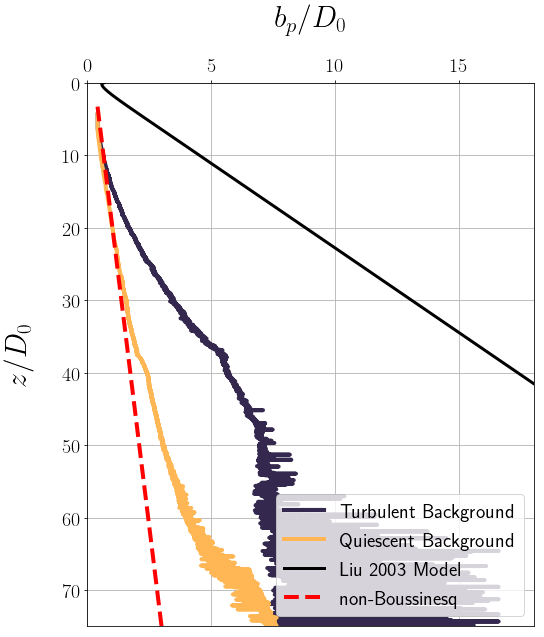

In [247]:
f,ax = plt.subplots(figsize=(8,10))
ax.plot(np.asarray(widths_t),widths_t_loc/cal/D_0,color=cmap_sunset.cmap(10),linewidth=4)
ax.plot(np.asarray(widths),widths_loc/cal/D_0,color='#ffb755',linewidth=4)
ax.plot(ra[1:]/np.sqrt(2)/D_0,np.linspace(0,s_size/cal*length/D_0,steps),'k',linewidth=3)
ax.plot(r_pnb/D_0,(z_pb)/D_0+3.3,'--',linewidth=4,color='r')

ax.set_xlabel('$b_p/D_0$',labelpad=25,fontsize=30);
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.set_xlim(0,18)
ax.grid()
ax.set_ylim(75,0)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('$z/D_0$',labelpad=25,fontsize=30)
ax.legend(['Turbulent Background','Quiescent Background','Liu 2003 Model','non-Boussinesq'],fontsize=20);
#ax.text(2,10,r'$\frac{db_{p,t_{1}}}{dz} = 0.057$',fontsize=24);
#ax.text(5,25,r'$\frac{db_{p,t_{2}}}{dz} = 0.184$',fontsize=24);
#ax.text(-6,28,r'$\frac{db_{p,q}}{dz} = 0.0502$',fontsize=24);

#f.savefig('/media/alec/Photography/AGU_2019/bp.pdf',format='pdf',bbox_inches='tight',transparent=True)

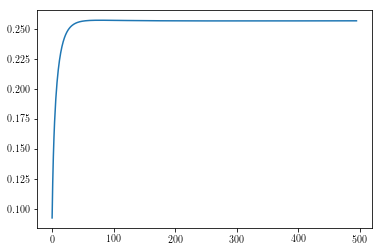

In [293]:
x = np.linspace(0,s_size/cal*length/D_0,steps)

ms = []
for i in range(4000,steps,1000):
    start = i
    stop = i+1000
    ms.append(np.polyfit(x[start:stop],ra[start:stop]/np.sqrt(2)/D_0,1)[0])
plt.plot(ms)


In [292]:
i

500000

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

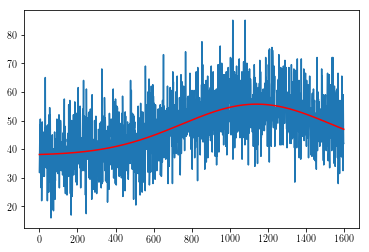

In [104]:
c=-10
y = t_image[:,c]
max_std = 800# (np.where(t_image[:,c]>60)[0][-1]-np.where(t_image[:,c]>60)[0][1])/
min_std=20
guess_std = (np.where(t_image[:,c]>60)[0][-1]-np.where(t_image[:,c]>60)[0][1])/4
min_offset = t_image[:,c].min()
max_offset = np.max(t_image[0:400,c])
#popt,pcov = curve_fit(gaussian,xt,y,p0=[y.max(),900,guess_std,30],bounds=((y.max()-50,700,min_std,min_offset),(y.max(),1200,800,max_offset)))
popt,pcov = curve_fit(gaussian,xt,y,p0=[y.max(),900,(np.where(t_image[:,c]>60)[0][-1]-np.where(t_image[:,c]>60)[0][1])/4,30])
#popt,pcov = curve_fit(cauchy,xt,y,p0=[guess_std,1000,25],bounds=((30,600,10),(800,1200,50)))
plt.plot(t_image[:,c])
plt.plot(gaussian(xt,popt[0],popt[1],popt[2],popt[3]),'r-')
plt.plot(np.where(y==y.max())[0],y.max(),'rx')

In [85]:
popt,y.max()

(array([ 213.        , 1021.17024504,  314.94370495,   18.5       ]), 223.0)

In [89]:
w=1/np.e*(gaussian(xt,popt[0],popt[1],popt[2],popt[3])-popt[3]).max()
first = np.where((gaussian(x,popt[0],popt[1],popt[2],popt[3])-popt[3])>w)[0][0]
middle = np.where((gaussian(x,popt[0],popt[1],popt[2],popt[3])-popt[3])==(gaussian(x,popt[0],popt[1],popt[2],popt[3]).max()-popt[3]))[0]
middle-first

array([627])

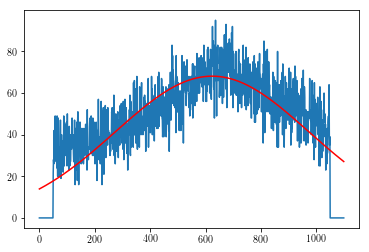

In [42]:
c=-48
y = image[:,c]
max_std = 800# (np.where(image[:,c]>60)[0][-1]-np.where(image[:,c]>60)[0][1])/2
min_std=20
min_offset = image[:,c].min()
max_offset = np.max(image[0:400,c])
popt,pcov = curve_fit(gaussian,x,y,p0=[y.max(),650,min_std,10],bounds=((y.max()-50,400,min_std,min_offset),(y.max()+50,800,max_std,max_offset)))
#popt,pcov = curve_fit(gaussian,x,y,p0=[y.max(),900,min_std,10])
plt.plot(image[:,c])
plt.plot(gaussian(x,popt[0],popt[1],popt[2],popt[3]),'r-')

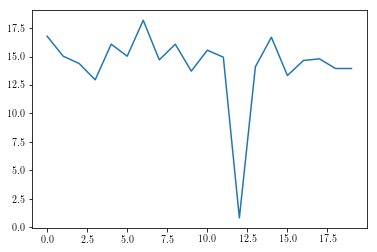

In [41]:
plt.plot(widths_t[-60:-40]*2/cal/D_0)

In [43]:
widths_t[-48]

array([27])

In [931]:
np.where(gaussian(x,popt[0],popt[1],popt[2],popt[3])>1/np.e*gaussian(x,popt[0],popt[1],popt[2],popt[3]).max())[0]

array([  93,   94,   95, ..., 1097, 1098, 1099])

In [991]:
1/np.e*gaussian(x,popt[0],popt[1],popt[2],popt[3]).max()-popt[3]

-12.71482920146045

In [995]:
1/np.e*gaussian(x,popt[0],popt[1],popt[2],popt[3]).max()-popt[3] + gaussian(x,popt[0],popt[1],popt[2],popt[3]).max()

38.854525177398074

In [997]:
first

554